In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)
    
def makeROCPlot(pred,true,label="",noSkill=True):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL")
    plt.legend()
    return auc

def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,color="black"):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

In [23]:
resolution = 60
window = 1.0
align = False

In [42]:
datadir = "D:/PeakDetective/data/cred_RP_T3/"
ms1ppm = 25
cutoff = 0.7 #default cutoff from last run

In [25]:
xcms_feats = pd.read_csv(datadir + "xcms_1T1_10069feature_2023-01-31.csv",index_col=1)
xcms_feats

,Unnamed: 0,mzmed,rtmed,int,npeaks,mzppm,rtdiff,peakwidth,pwidthdiff
index,,,,,,,,,
1,1,101.060301,1674.654541,42013.249004,3,9.946848,0.046875,10.467896,0.927368
2,2,101.060447,944.591431,9450.463743,3,29.132909,0.525085,10.848226,1.521118
3,3,101.097644,2338.475049,24506.774649,6,26.919623,13.250244,8.837484,6.000000
4,4,101.097722,2359.980225,25642.680893,4,26.261218,14.510254,8.937073,5.251953
5,5,101.097923,2377.611084,30398.670641,3,21.902387,3.995117,10.334961,2.496094
...,...,...,...,...,...,...,...,...,...
10206,10065,1596.285897,1750.804321,126009.297448,3,3.248334,0.439697,10.879720,0.282104
10207,10066,1597.291948,1751.161743,38530.126058,3,14.310516,0.534058,23.951050,35.125977
10208,10067,1597.305885,1789.318909,49470.689405,5,4.248994,5.488892,10.122339,8.374146


In [26]:
credentialed_feats = pd.read_csv(datadir + "credential_demo_CredentialedPeaks.csv",index_col=0)
toDrop = [index for index,row in credentialed_feats.iterrows() if pd.isna(row["cc1"])]
credentialed_feats = credentialed_feats.drop(toDrop,axis=0)
credentialed_feats = credentialed_feats.astype({"cc1":"int"})
credentialed_feats = credentialed_feats.set_index("cc1")
credentialed_feats

,mz1,rt1,i1,knot1,tail1,quipu1,charge1,mainmz11,mainmz21,ncar1,...,i2,knot2,tail2,quipu2,charge2,mainmz12,mainmz22,ncar2,ratio2,ratio1_ratio2
cc1,,,,,,,,,,,,,,,,,,,,,
9,102.054605,91.424316,91111.489633,2369.0,0.0,414.0,1.0,102.054605,106.068968,4.0,...,59498.425547,2343.0,0.0,382.0,1.0,102.054605,106.068968,4.0,0.241618,1.913417
23,103.058914,92.180923,3233.836703,2369.0,0.0,414.0,1.0,102.054605,106.068968,4.0,...,8071.264181,4233.0,0.0,382.0,1.0,102.054605,106.068968,4.0,0.241618,1.913417
32,105.065300,91.400120,7647.142448,4321.0,0.0,414.0,1.0,102.054605,106.068968,4.0,...,246250.260867,4233.0,0.0,382.0,1.0,102.054605,106.068968,4.0,0.241618,1.913417
35,106.068968,91.649559,197076.453861,4321.0,0.0,414.0,1.0,102.054605,106.068968,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,114.091867,119.111065,243561.913813,1980.0,0.0,320.0,0.0,114.091867,120.112070,0.0,...,112027.722368,1941.0,0.0,277.0,0.0,114.091867,120.112070,0.0,0.403087,2.720447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10065,1552.108481,1804.689697,33695.430781,3831.0,0.0,1144.0,1.0,1551.100867,1592.238259,41.0,...,12545.918370,3762.0,0.0,1044.0,1.0,1551.100867,1592.238259,41.0,0.135411,1.974964
10195,1591.233499,1804.566284,98074.642583,4829.0,0.0,1144.0,1.0,1551.100867,1592.238259,41.0,...,76158.063967,4694.0,0.0,1044.0,1.0,1551.100867,1592.238259,41.0,0.135411,1.974964
10197,1592.238259,1804.566284,219861.102071,4829.0,0.0,1144.0,1.0,1551.100867,1592.238259,41.0,...,167459.683291,4694.0,0.0,1044.0,1.0,1551.100867,1592.238259,41.0,0.135411,1.974964


In [27]:
xcms_feats["credentialed"] = xcms_feats.index.isin(credentialed_feats.index.values)
xcms_feats = xcms_feats.rename(mapper={"mzmed":"mz"},axis=1)
xcms_feats["rt"] = xcms_feats["rtmed"].values / 60
xcms_feats = xcms_feats[["mz","rt","credentialed"]]
xcms_feats

,mz,rt,credentialed
index,,,
1,101.060301,27.910909,False
2,101.060447,15.743191,False
3,101.097644,38.974584,False
4,101.097722,39.333004,False
5,101.097923,39.626851,False
...,...,...,...
10206,1596.285897,29.180072,False
10207,1597.291948,29.186029,False
10208,1597.305885,29.821982,False


In [28]:
files = [x for x in os.listdir(datadir + "1T1/") if ".mzML" in x][:1]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + "1T1/" + file,ms1ppm)
    temp.rts = [x/60 for x in temp.rts]
    temp.data = {rt/60:data for rt,data in temp.data.items()}
    raw_data.append(temp)
    

['1FN060_09_EC_11mix_1.mzML']


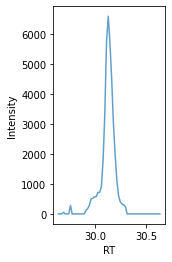

In [31]:
inds = list(xcms_feats.index.values)
rd.shuffle(inds)
plt.figure(figsize=(2,4))
for i in inds:
    if xcms_feats.at[i,"credentialed"] == False:
        plot_overlayedEIC(raw_data,xcms_feats.at[i,"mz"],xcms_feats.at[i,"rt"]-.5,xcms_feats.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break



In [32]:
integ = PeakDetective.PeakDetective(numCores = 10,resolution=resolution)

In [33]:
if __name__ == "__main__":
    X = integ.makeDataMatrix(raw_data,xcms_feats["mz"],xcms_feats["rt"],align=False)
    

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [34]:
pkl.dump([X],open(datadir + "model_selection_data.pkl","wb"))

(array([  21., 1172., 3391., 2711., 1525.,  645.,  352.,  167.,   67.,
          18.]),
 array([2.93895676, 3.41410215, 3.88924755, 4.36439294, 4.83953834,
        5.31468373, 5.78982913, 6.26497452, 6.74011992, 7.21526531,
        7.69041071]),
 <BarContainer object of 10 artists>)

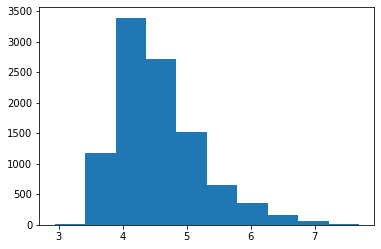

In [35]:
plt.hist(np.log10(X.sum(axis=1)+2))

In [36]:
[X] = pkl.load(open(datadir + "model_selection_data.pkl","rb"))

In [37]:
if __name__ == "__main__":
    integ.trainSmoother(xcms_feats,raw_data,100000,10,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/10
1407/1407 [==============================] - 25s 17ms/step - loss: 0.1304 - mean_absolute_error: 0.0558 - val_loss: 0.0803 - val_mean_absolute_error: 0.0147
Epoch 2/10
1407/1407 [==============================] - 25s 18ms/step - loss: 0.0762 - mean_absolute_error: 0.0130 - val_loss: 0.0742 - val_mean_absolute_error: 0.0119
Epoch 3/10
1407/1407 [==============================] - 26s 18ms/step - loss: 0.0732 - mean_absolute_error: 0.0112 - val_loss: 0.0726 - val_mean_absolute_error: 0.0106
Epoch 4/10
1407/1407 [==============================] - 26s 18ms/step - loss: 0.0719 - mean_absolute_error: 0.0104 - val_loss: 0.0716 - val_mean_absolute_error: 0.0101
Epoch 5/10
1407/1407 [==============================] - 25s 18ms/step - loss: 0.0710 - mean_absolute_error: 0.0098 - val_loss: 0.0709 - val_mean_absolute_error: 0.0096
Epoch 6/10
1407/1407 [==================

In [38]:
integ.save(datadir + "smoothed_only/")

In [39]:
integ.load(datadir + "smoothed_only/")

1/1 [==============================] - 0s 20ms/step
loss: 0.5700086355209351 mean_absolute_error: 0.353892982006073 val loss: 0.3889434039592743 val_mean_absolute_error: 0.20687568187713623 numEpochs: 999
312/312 [==============================] - 0s 1ms/step


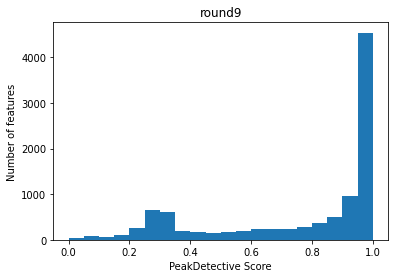

9969 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


1/1 [==============================] - 0s 19ms/step


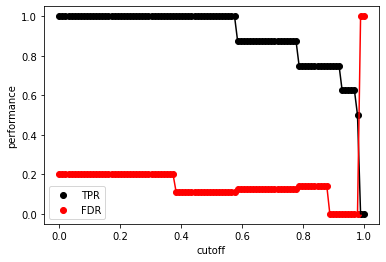

In [40]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,[],[],200,1000,4,1,numVal = 10,numManualPerRound=10,inJupyter=True)

In [41]:
cutoff = 0.7

In [43]:
integ.save(datadir + "active/")

In [44]:
integ.load(datadir + "active/")

In [45]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,xcms_feats,threshold=cutoff,align=align)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
315/315 [==============================] - 0s 1ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 


In [46]:
peak_curated

,mz,rt,credentialed,D:/PeakDetective/data/cred_RP_T3/1T1/1FN060_09_EC_11mix_1.mzML
index,,,,
1,101.060301,27.910909,False,1.0
2,101.060447,15.743191,False,1.0
3,101.097644,38.974584,False,0.0
4,101.097722,39.333004,False,0.0
5,101.097923,39.626851,False,0.0
...,...,...,...,...
10206,1596.285897,29.180072,False,1.0
10207,1597.291948,29.186029,False,0.0
10208,1597.305885,29.821982,False,1.0


In [54]:
credTrue = 0
credArt = 0
nonCredTrue = 0
nonCredArt = 0
for index,row in peak_curated.iterrows():
    if row["credentialed"]:
        if row[raw_data[0].filename] > 0.5:
            credTrue += 1
        else:
            credArt += 1
    else:
        if row[raw_data[0].filename] > 0.5:
            nonCredTrue += 1
        else:
            nonCredArt += 1
print(credTrue,credArt,credTrue/(credTrue+credArt))
print(nonCredTrue,nonCredArt,nonCredTrue/(nonCredTrue+nonCredArt))

2241 629 0.7808362369337979
4646 2553 0.645367412140575
